In [3]:
import scipy.stats as sps
import matplotlib.pyplot as plt
from matplotlib import gridspec
import seaborn as sns
import numpy as np
import pandas as pd
from tqdm import tqdm
from statsmodels.stats.proportion import proportion_confint

In [4]:
import warnings
warnings.filterwarnings('ignore')

# Стратификация

Цель данного ноутбука - реализовать стратифицированное разделение пользователей на группы,  
сравнить проведение тестов с использованием стратификации, постстратификации, без дополнений  
и узнать, какой выигрыш в снижении дисперсии и времени проведения теста может дать стратификация.


*Мотивация*  
Посмотрим на формулу расчета необходимого количества наблюдейний в выборках:  
$$n = \frac{(z_{1-\alpha} * z_{\beta}) * (\sigma^2_1 + \sigma^2_2)} {\varepsilon^2}$$  
$\alpha$ и $\beta$ у нас обычно зафиксированы, $\varepsilon$ мы менять не хотим,  
поэтому если мы хотим уменьшить необходимое число наблюдений в выборках, то приходится уменьшать диисперсию в выборках.  
В этом нам и должна помочь стратификация.

В чем заключается суть стратификации?  
Допустим у нас есть некоторые группы пользователей (страты), которые чем-то отличаются.  
Классический пример - операционные системы пользователей. Зачастую пользователи с ОС от Apple готовы тратить больше денег на различные услуги.  
Например, в игре Hearthstone цена внутреигровых покупок напрямую зависит от типа устройства пользователя,  
и люди, играющие с Iphone\Mac вынуждены платить больше.  
При стратифицированном разделении людей на группы мы набираем пользователей поровну из каждой страты а затем считаем среднее по стратам и усредняем его с учетов весов страт.  
за счет того, что поведение пользователей внутри страт отличается меньше, чем по всем пользователям, мы можем снизить дисперсию в выборках.

Давайте это реализуем

In [ ]:
class MixedDistribution:
    '''
        Класс MixedDistribution хранит в себе комбинированную выборку из нескольких распределения.
        Функция get_casual_partition возвращает 2 случайные выборки размера group_size из смешанного распределения
        Функция get_strat_partition возвращает 2 стратифицированные выборки размера group_size из смешанного распределения
    '''
    def __init__(self, distrs, sizes, draw_plot=False):
        sample, strats = np.array([]), np.array([])
        for i, distr in enumerate(distrs):
            sample = np.concatenate((sample, distr.rvs(size=sizes[i])))
            strats = np.concatenate((strats, np.full(sizes[i], i)))
    
        self.data = pd.DataFrame({'value': sample, 'strat': strats})
        self.weights = np.array((self.data.groupby(by='strat').count() / self.data.groupby(by='strat').count().sum())['value'])
        self.strat_count = len(sizes)
        if draw_plot:
            with sns.axes_style('darkgrid'):
                plt.figure(figsize=(9, 6))
                plt.title('Плотность распределений')
                sns.kdeplot(data=self.data, x='value', color='r' , linestyle='--', lw=2, label='kde итогового распределения')
                sns.kdeplot(data=self.data, x='value', hue='strat', lw=2, palette='deep', label='kde одного из исходных распределений')
                plt.xlabel('Значение')
                plt.ylabel('Плотность')
                plt.legend()
                plt.show()

    def get_casual_partition(self, group_size):
        return self.data.sample(group_size, replace=True), \
                self.data.sample(group_size, replace=True)

    def get_strat_partition(self, group_size):
        groups = [pd.DataFrame(), pd.DataFrame()]
        for i in range(2):
            for strat in range(self.strat_count):
                groups[i] = pd.concat((groups[i], \
                            self.data[self.data.strat == strat].sample(int(group_size * self.weights[strat]), replace=True)))
        return groups

In [5]:
class MixedDistribution:
    '''
        Класс MixedDistribution хранит в себе комбинированную выборку из нескольких распределения.
        Функция get_casual_partition возвращает 2 случайные выборки размера group_size из смешанного распределения
        Функция get_strat_partition возвращает 2 стратифицированные выборки размера group_size из смешанного распределения
    '''
    def draw_distr_plot(self, ax=None):
        with sns.axes_style('darkgrid'):
            if ax is None:
                fig, ax = plt.subplots(figsize=(9, 6))
                plt.title('Плотность распределений')
                plt.xlabel('Значение')
                plt.ylabel('Плотность')
            sns.kdeplot(data=self.data, x='value', ax=ax, color='r' , linestyle='--', lw=2, label='kde итогового распределения')
            sns.kdeplot(data=self.data, x='value', ax=ax, hue='strat', lw=2, palette='deep', label='kde одного из исходных распределений')
            # plt.legend()
            # plt.show()

    def __init__(self, distrs, sizes, draw_plot=False):
        sample, strats = np.array([]), np.array([])
        for i, distr in enumerate(distrs):
            sample = np.concatenate((sample, distr.rvs(size=sizes[i])))
            strats = np.concatenate((strats, np.full(sizes[i], i)))
    
        self.data = pd.DataFrame({'value': sample, 'strat': strats})
        self.weights = np.array((self.data.groupby(by='strat').count() / self.data.groupby(by='strat').count().sum())['value'])
        self.strat_count = len(sizes)
        if draw_plot:
            self.draw_distr_plot()

    def get_casual_partition(self, group_size):
        return self.data.sample(group_size, replace=True), \
                self.data.sample(group_size, replace=True)

    def get_strat_partition(self, group_size):
        groups = [pd.DataFrame(), pd.DataFrame()]
        for i in range(2):
            for strat in range(self.strat_count):
                groups[i] = pd.concat((groups[i], \
                            self.data[self.data.strat == strat].sample(int(group_size * self.weights[strat]), replace=True)))
        return groups

Так как мы знаем размер выборки, которую мы возьмем, мы могли бы строго сохранить баланс наблюдений,  
которые семплируем из каждой страты с точностью до единицы.  
Однако в реальной жизни разделение на группы обычно происходит в онлайне, например, чтобы поддерживать возможность показывать пользователю разные версии страницы.  
Поэтому внутри каждой страты мы делим наблюдения на тест/контроль так же рандомно, имитируя онлайн алгоритм разделения.

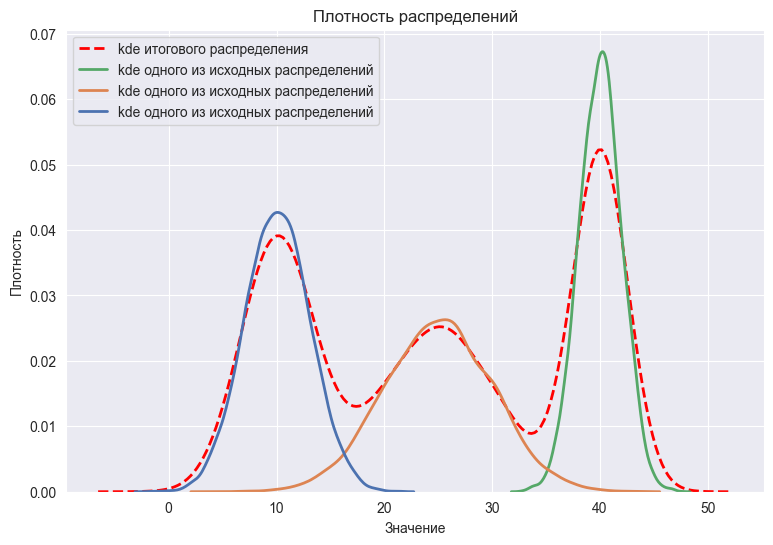

In [48]:
distrs = [sps.norm(10, 3), sps.norm(25, 5), sps.norm(40, 2)]
size = 10 ** 4
sizes = [size for i in range(3)]
mixed = MixedDistribution(distrs, sizes, draw_plot=True)

В графике явно видны выделяющиеся страты в итоговом распределении

Теперь реализуем функции подсчета обычного среднего и стратифицированного

In [6]:
def calc_casual_mean(samples):
    means = []
    for sample in samples:
        means.append(sample.value.mean())
    return means[0] if len(means) == 1 else means

In [7]:
def calc_strat_mean(samples, mixed_d: MixedDistribution):
    means = []
    for sample in samples:
        cur_mean = np.array(sample.groupby(by='strat').mean().value) * mixed_d.weights
        means.append(cur_mean.sum())
    return means[0] if len(means) == 1 else means

Теперь посмотрим на распределение разницы средних при использовании стратификации, постстратификации и без стратификации

In [8]:
def get_mean_diff(mixed_d: MixedDistribution, sample_size=1000, n_iter=10000):
    mean_diff = {'strat': [], 'nostrat': [], 'poststrat': []}
    for i in tqdm(range(n_iter)):
        X1, X2 = mixed_d.get_casual_partition(sample_size)

        nostrat_means = calc_casual_mean([X1, X2])
        mean_diff['nostrat'].append(nostrat_means[0] - nostrat_means[1])

        poststrat_means = calc_strat_mean([X1, X2], mixed_d)
        mean_diff['poststrat'].append(poststrat_means[0] - poststrat_means[1])

        X1_strat, X2_strat = mixed_d.get_strat_partition(sample_size)
        strat_means = calc_strat_mean([X1_strat, X2_strat], mixed_d)
        mean_diff['strat'].append(strat_means[0] - strat_means[1])

    return mean_diff

In [9]:
def draw_mean_diff_plot(mixed_d: MixedDistribution, sample_size=1000, n_iter=10000, ax=None):
    if ax is None:
        fig, ax = plt.subplots()

    mean_diff = get_mean_diff(mixed_d, sample_size, n_iter)

    with sns.axes_style('darkgrid'):
        ax.set_title('Размер выборок {}'.format(sample_size))
        sns.kdeplot(x=mean_diff['nostrat'], ax=ax, lw=2, label='Без стратификации')
        sns.kdeplot(x=mean_diff['poststrat'], ax=ax, lw=2, label='Постстратификация')
        sns.kdeplot(x=mean_diff['strat'], ax=ax, lw=2, label='Стратификация')
        ax.set_ylabel('')
    

In [10]:
def draw_mean_diff_plots(mixed_d: MixedDistribution, sizes=[100, 500, 1000], n_iter=10000, nrows=1, ncols=3, figsize=(12, 6)):
    with sns.axes_style('darkgrid'):
        fig, axes = plt.subplots(nrows, ncols, figsize=figsize)
        plt.suptitle('Распределение разности средних для разных размеров выборок, \n количество итераций: {}'.format(n_iter))
        for size, ax in zip(sizes, axes.flatten()):
            draw_mean_diff_plot(mixed_d, sample_size=size, n_iter=n_iter, ax=ax)
        handles, labels = axes.flatten()[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper right')
        fig.supylabel('Плотность')
        fig.supxlabel('Значение')
        fig.show()

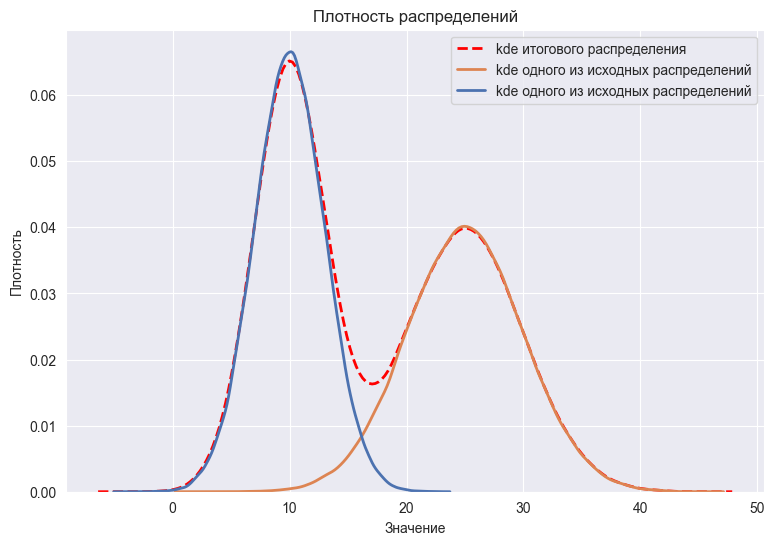

In [179]:
distrs = [sps.norm(10, 3), sps.norm(25, 5)]
size = 10 ** 5
sizes = [size for i in range(len(distrs))]
mixed_2_strat = MixedDistribution(distrs, sizes, draw_plot=True)

100%|██████████| 5000/5000 [01:20<00:00, 62.45it/s]


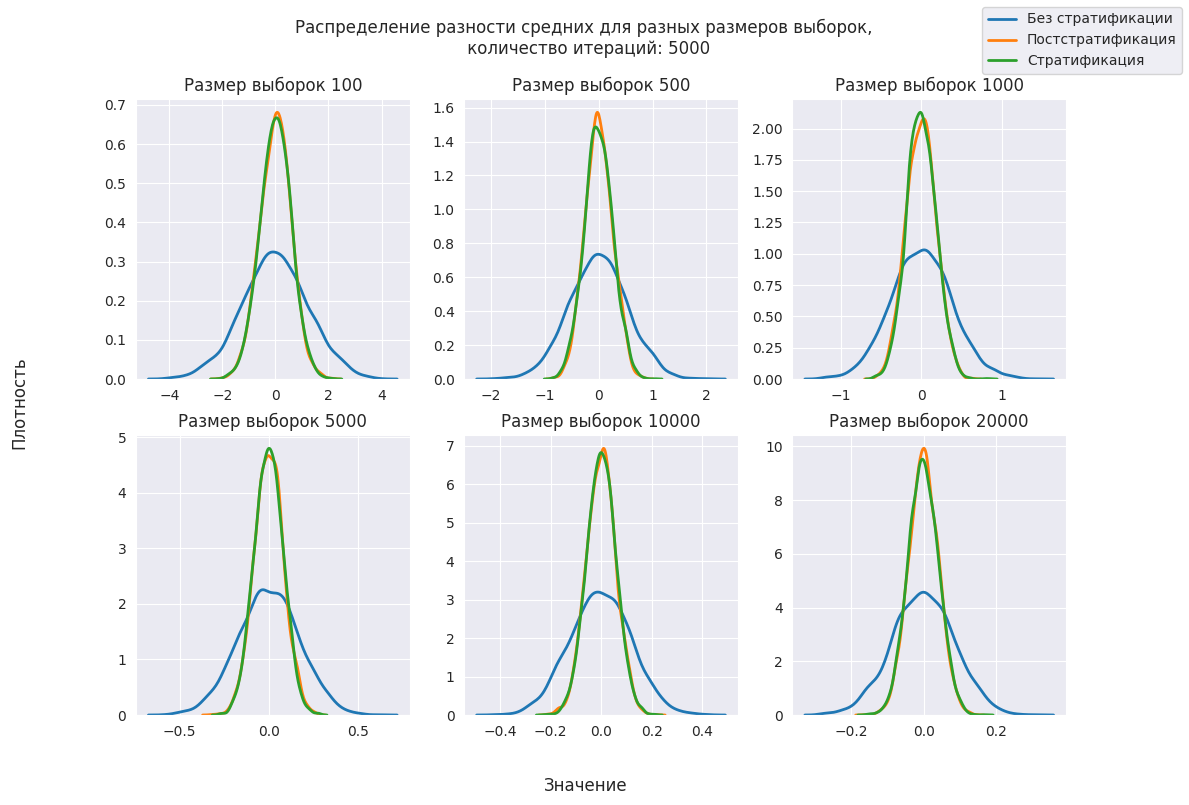

In [181]:
sizes = [100, 500, 1000, 5000, 10000, 20000]
draw_mean_diff_plots(mixed_2_strat, sizes=sizes, n_iter=5000, nrows=2, ncols=3, figsize=(12, 8))

Я сразу писал код для построения нескольких графиков, так как ожидал, что с ростом размеры выборки эффект от стратификации будет снижаться, в виду того, что перекосы по стратам будут меньше.  
Однако можно видеть, что форма распределений практически не меняется, с ростом размера выборки только снижается абсолютное значение дисперсии.  
Так как при стратификации и постстратификации результаты получаются практически однаковые, можно сделать вывод, что влияение оказывает не механизм сплитования, а использования стратифицированного среднего.  
Чтобы понять, почему графики распределений получились такими посмотрим на формулы дисперсии средних в различных вариациях.

![Дисперсия средних](../pictures/strat_var.png)

Картинка взята [отсюда](https://habr.com/ru/companies/X5Tech/articles/596279/), там же можно посмотреть вывод этих формул.  
По формулам мы видим, что дисперсия снижается линейно в зависимости от размера выборок, причем в случае постстратификации в дисперсии  
есть дополнительное слагаемое относительно стратификации, однако оно имеет множитель $\frac{1}{n^2}$, поэтому не оказывает большого влияния.  
При случайной разбиении и обычном среднем дополнительно слагаемое уже имеет коэффициент $\frac{1}{n}$, поэтому оказывает существенное влияение.  
В нашем случае $w_{1, 2}=0.5$, поэтому можно вынести их за сумму, $\sigma^2_1 + \sigma^2_2 = 25 + 9 = 34$, $(\mu_1 - \mu)^2 + (\mu_2 - \mu)^2 = 112.5$,  
поэтому использование стратифицированного среднего оказывает большое влияние на дисперсию вне зависимости от размера выборок.

Давайте подробнее посмотрим на влияние стратификации в зависимости от количества страт и от разницы матожиданий в стратах.

In [298]:
def draw_mean_distr_by_strats_num(strats_pack, size=10 ** 3, n_iter=10 ** 4, figsize=(12, 8), total_size=10 ** 5):
    with sns.axes_style('darkgrid'):
        fig, axes = plt.subplots(2, len(strats_pack), figsize=figsize)
        plt.suptitle('Распределение разности средних для разного количества страт, \n количество итераций: {}, размер выборок: {}'.format(n_iter, size))

        for row in range(len(strats_pack)):
            mixed_d = MixedDistribution(strats_pack[row], [total_size for i in range(len(strats_pack[row]))], draw_plot=False)
            mixed_d.draw_distr_plot(ax=axes[0, row])
            axes[0, row].set_xlabel('')
            axes[0, row].set_ylabel('')
            axes[0, row].set_title(f'Распределение из {len(strats_pack[row])} страт', fontsize=12)
            draw_mean_diff_plot(mixed_d, sample_size=size, n_iter=n_iter, ax=axes[1, row])
            axes[1, row].set_title(f'Распределение разности средних\nиз распределения из {len(strats_pack[row])} страт', fontsize=12)
        
        handles, labels = axes[0, -1].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper left', fontsize='small')
        handles, labels = axes[1, -1].get_legend_handles_labels()
        fig.legend(handles, labels, loc='lower left', fontsize='small')
        fig.supylabel('Плотность')
        fig.supxlabel('Значение')
        fig.show()

100%|██████████| 10000/10000 [02:19<00:00, 71.56it/s]


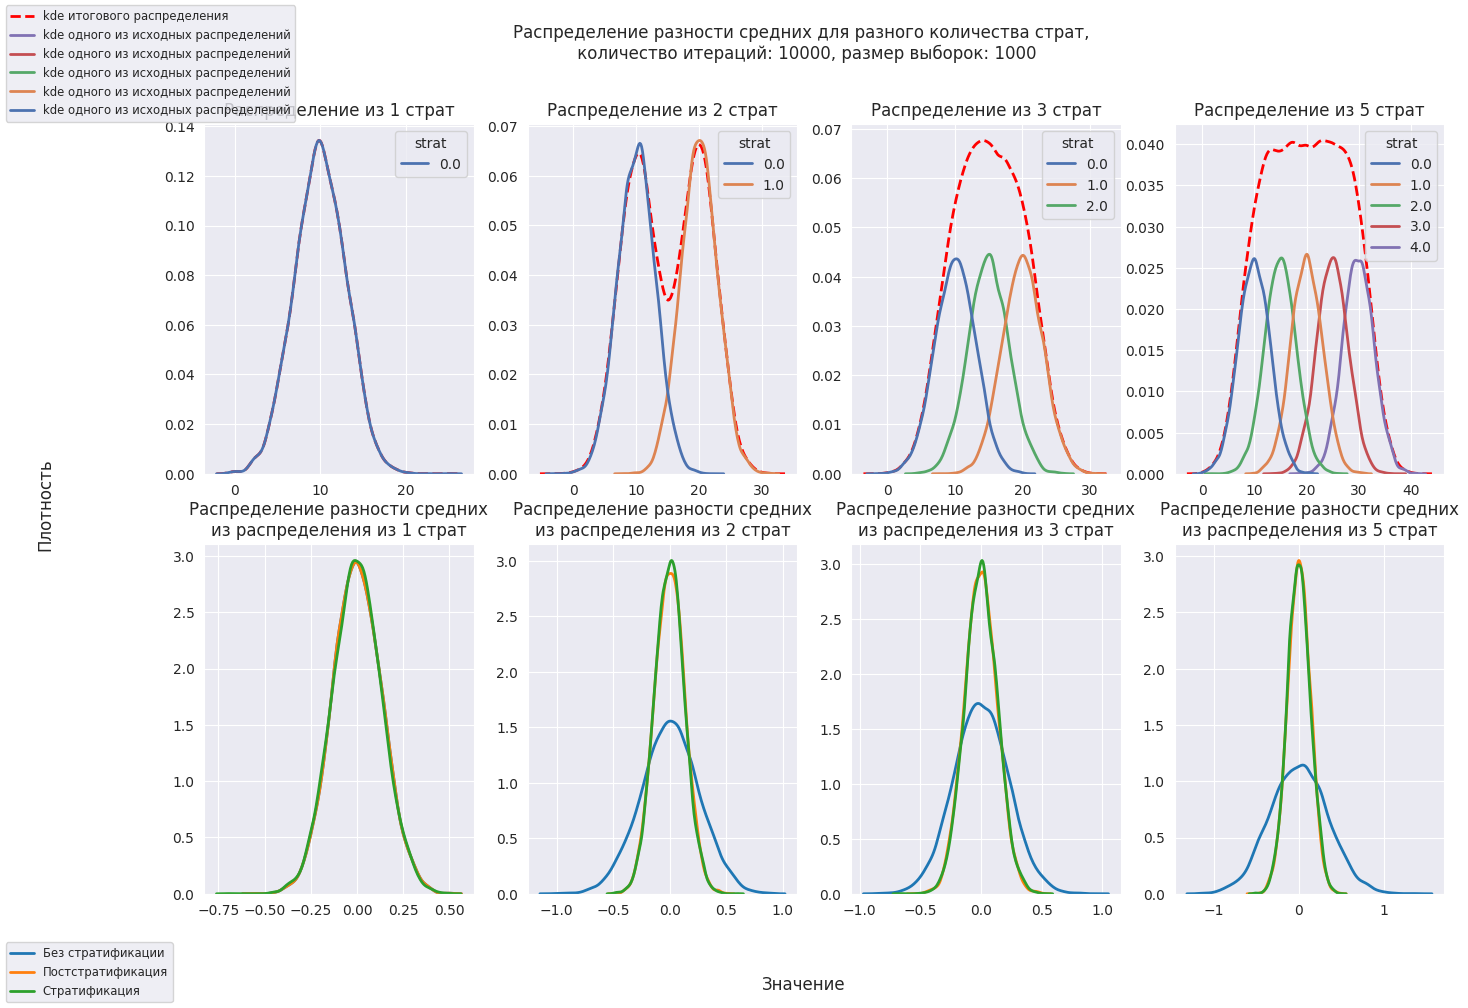

In [299]:
distrs = [sps.norm(10, 3), sps.norm(20, 3), sps.norm(15, 3), sps.norm(25, 3)]
strats_pack = [distrs[:i] for i in range(1, len(distrs) + 1)]
strats_pack[-1].append(sps.norm(30, 3))
draw_mean_distr_by_strats_num(strats_pack, n_iter=10000, total_size=10000, figsize=(16, 10))

Можно видеть, что при переходе к трем стратам эффект от стратификации даже снизился.  
Это связано с тем, что третья страта была вставлена между первыми двумя, таким образом она не увеличила  
обычную дисперсию средних, а веса страт только снизились.  
Помимо этого случая видна тенденция, что при увеличении количества страт обычная дисперсия средних становится  
все больше относительно стратифицированной.

In [295]:
def draw_mean_distr_by_strat_shift(strats_pack, shifts, size=10 ** 3, n_iter=10 ** 4, figsize=(12, 8), total_size=10 ** 5):
    with sns.axes_style('darkgrid'):
        fig, axes = plt.subplots(2, len(strats_pack), figsize=figsize)
        plt.suptitle('Распределение разности средних для разного количества страт, \n количество итераций: {}, размер выборок: {}'.format(n_iter, size))

        for row in range(len(strats_pack)):
            mixed_d = MixedDistribution(strats_pack[row], [total_size for i in range(len(strats_pack[row]))], draw_plot=False)
            mixed_d.draw_distr_plot(ax=axes[0, row])
            axes[0, row].set_xlabel('')
            axes[0, row].set_ylabel('')
            axes[0, row].set_title(f'Смешанное распределение,\nсдвиг второй страты {shifts[row]}', fontsize=12)
            draw_mean_diff_plot(mixed_d, sample_size=size, n_iter=n_iter, ax=axes[1, row])
            axes[1, row].set_title(f'Распределение разности средних\nиз распределения выше', fontsize=12)
        
        handles, labels = axes[0, -1].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper left', fontsize='small')
        handles, labels = axes[1, -1].get_legend_handles_labels()
        fig.legend(handles, labels, loc='lower left', fontsize='small')
        fig.supylabel('Плотность')
        fig.supxlabel('Значение')
        fig.show()

100%|██████████| 10000/10000 [01:19<00:00, 125.14it/s]


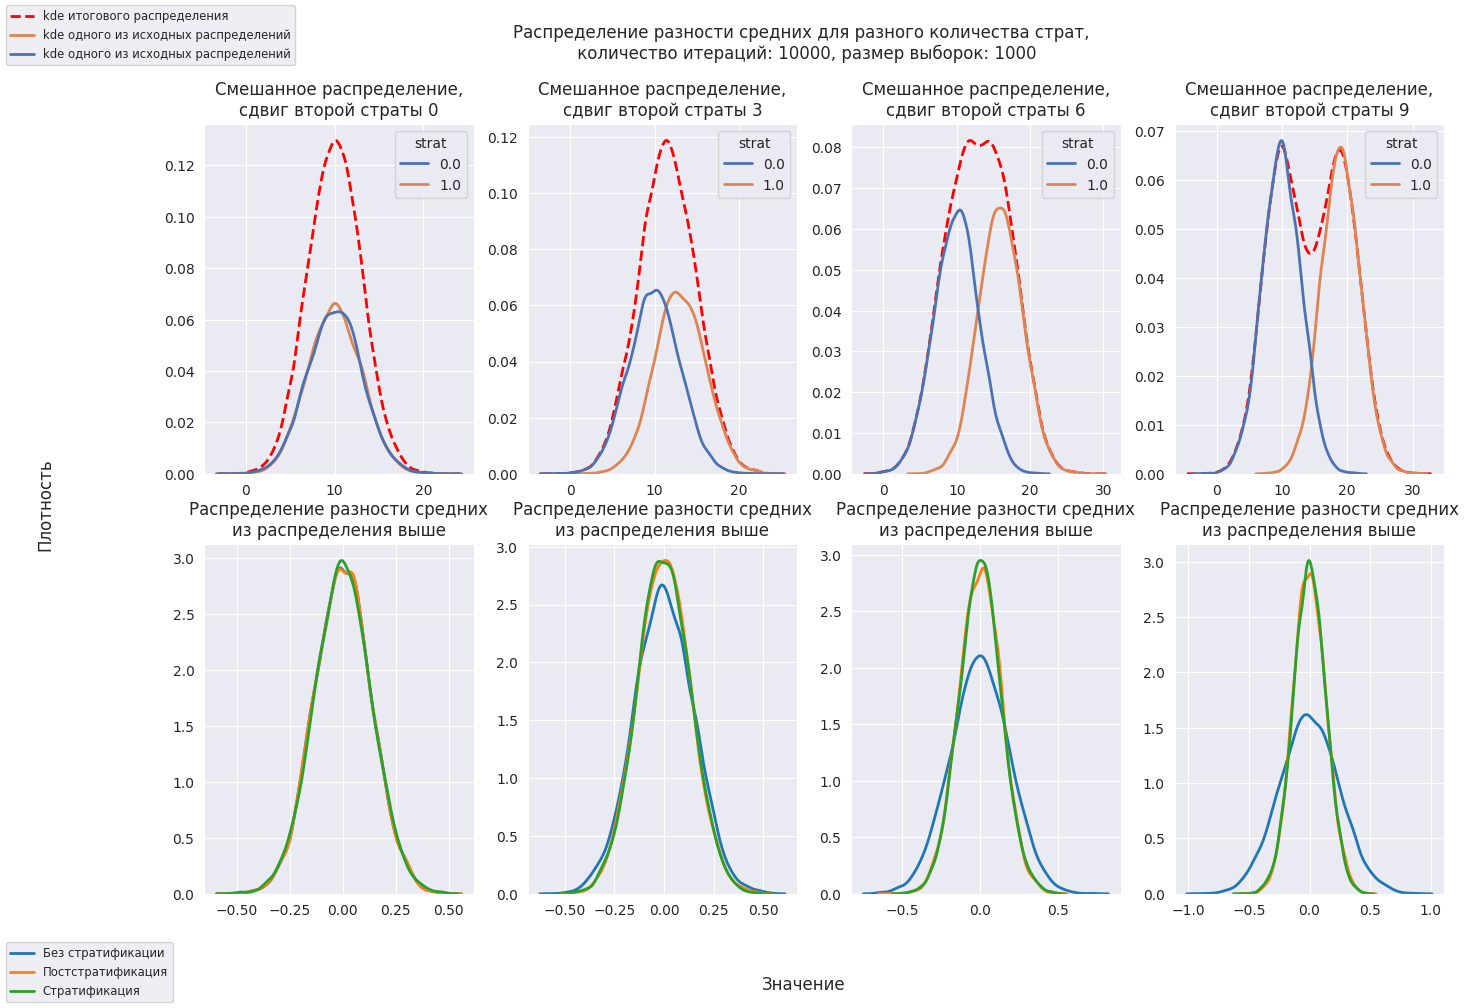

In [296]:
mean, sigma, shift, iter = 10, 3, 3, 4
first_strat = sps.norm(mean, sigma)
strats_pack = [[first_strat, sps.norm(mean + shift * i, sigma)] for i in range(iter)]
shifts = [shift * i for i in range(iter)]
draw_mean_distr_by_strat_shift(strats_pack, shifts, n_iter=10000, total_size=10000, figsize=(16, 10))

Здесь аналогично видим, что чем больше разность средних, тем больше станосится дисперсия разности средних в случае, когда мы не используем стратификацию.  
При применении стратификации форма распределения средних не меняется.

Давайте теперь напишем функцию теста с использованием стратификации и посмотрим, как она влияет на тест.

In [11]:
def get_mean(mixed_d: MixedDistribution, sample):
    return sample.value.mean()

def get_strat_mean(mixed_d: MixedDistribution, sample):
    return np.sum(np.array(sample.groupby(by='strat').mean().value) * mixed_d.weights)

def get_var(mixed_d: MixedDistribution, sample):
    return sample.value.var() / len(sample)

def get_strat_var(mixed_d: MixedDistribution, sample):
    return np.sum(np.array(sample.groupby(by='strat').var().value) * mixed_d.weights) / len(sample)

def get_poststrat_var(mixed_d: MixedDistribution, sample):
    return get_strat_var(mixed_d, sample) + \
        np.sum(np.array(sample.groupby(by='strat').var().value) * (1 - mixed_d.weights)) / len(sample) ** 2

In [12]:
mean_f = {'strat': get_strat_mean, 'nostrat': get_mean, 'poststrat': get_mean}
var_f = {'strat': get_strat_var, 'nostrat': get_var, 'poststrat': get_poststrat_var}

def ttest(mixed_d: MixedDistribution, samples, type_: 'strat' or 'poststrat' or 'nostrat', alpha = 0.05):
    mean = [mean_f[type_](mixed_d, sample) for sample in samples]
    var = [var_f[type_](mixed_d, sample) for sample in samples]
    t_stat = (mean[0] - mean[1]) / np.sqrt(var[0] + var[1])
    pvalue = 2 * sps.norm.cdf(x=-np.abs(t_stat))

    return int(pvalue < alpha)

In [13]:
def draw_reject_plot(calc_alpha, left_alpha, right_alpha, t_alpha):
    with sns.axes_style('whitegrid'):
        plt.figure(figsize=(9, 3))
        plt.hlines(0, 0, 1, color='black', lw=2, alpha=0.6)
        plt.vlines(t_alpha, -1, 1, color='r', lw=5, linestyle='--', alpha=0.6, label=r'Целевое значение $\alpha$')
        plt.fill_between([left_alpha, right_alpha], [0.15] * 2, [-0.15] * 2, color='g', alpha=0.6, label=r'Доверительный интервал для $\alpha$')
        plt.scatter(calc_alpha, 0, s=300, marker='*', color='r', label=r'Наблюдаемое $\alpha$')
        plt.xlim((min(t_alpha, left_alpha) - 0.005, max(t_alpha, right_alpha) + 0.005))
        plt.ylim((-0.5, 0.5))
        plt.title('')
        plt.yticks([])
        plt.legend()
        plt.show()

In [14]:
def draw_reject_plot(calc_alpha, left_alpha, right_alpha, t_alpha, ax=None):
    with sns.axes_style('whitegrid'):
        # plt.figure(figsize=(9, 3))
        ax.hlines(0, 0, 1, color='black', lw=2, alpha=0.6)
        ax.vlines(t_alpha, -1, 1, color='r', lw=5, linestyle='--', alpha=0.6, label=r'Целевое значение $\alpha$')
        ax.fill_between([left_alpha, right_alpha], [0.15] * 2, [-0.15] * 2, color='g', alpha=0.6, label=r'Доверительный интервал для $\alpha$')
        ax.scatter(calc_alpha, 0, s=300, marker='*', color='r', label=r'Наблюдаемое $\alpha$')
        ax.set_xlim((min(t_alpha, left_alpha) - 0.005, max(t_alpha, right_alpha) + 0.005))
        ax.ylim((-0.5, 0.5))
        ax.set_title('gdgds')
        # plt.yticks([])
        # plt.legend()
        # plt.show()

In [23]:
def draw_rejects_plot(calc_val, left, right, teor):
    # fig = plt.figure(figsize=(9, 9))
    gs = gridspec.GridSpec(3, 1)
    for i in range(3):
        draw_reject_plot(calc_val[i], left[i], right[i], teor, ax=plt.subplot(gs[i]))

In [16]:
def AB_test(strats, total_size=10 ** 6, sample_size=10 ** 3, n_iter=10 ** 3, alpha=0.05):
    rejects = {'strat': 0, 'nostrat': 0, 'poststrat': 0}
    mixed_d = MixedDistribution(strats, sizes=[total_size for i in range(len(strats))])
    for _ in tqdm(range(n_iter)):
        for type_ in rejects.keys():
            if type_ != 'strat':
                rand_samples = mixed_d.get_casual_partition(sample_size)
            else:
                rand_samples = mixed_d.get_strat_partition(sample_size)
            rejects[type_] += ttest(mixed_d, rand_samples, type_=type_)
    return rejects
    
    for type_ in rejects.keys():
        calc_alpha = rejects[type_] / n_iter
        left_alpha, right_alpha = proportion_confint(rejects[type_], n_iter, method='wilson')
        draw_reject_plot(calc_alpha, left_alpha, right_alpha, alpha)

In [17]:
a = AB_test([sps.norm(10, 3), sps.norm(20, 3)], total_size=10**5)

100%|██████████| 1000/1000 [00:20<00:00, 49.99it/s]


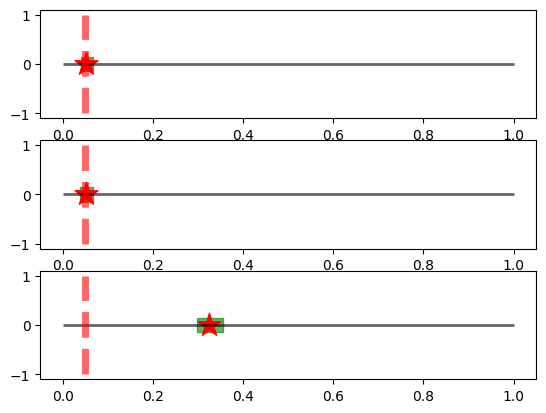

In [26]:
b = [[], [], []]
n_iter = 1000
alpha = 0.05
for i, type_ in enumerate(a.keys()):
    calc_alpha = a[type_] / n_iter
    left_alpha, right_alpha = proportion_confint(a[type_], n_iter, method='wilson')
    b[0].append(calc_alpha)
    b[1].append(left_alpha)
    b[2].append(right_alpha)
#     = [calc_alpha, left_alpha, right_alpha]
draw_rejects_plot(b[0], b[1], b[2], alpha)

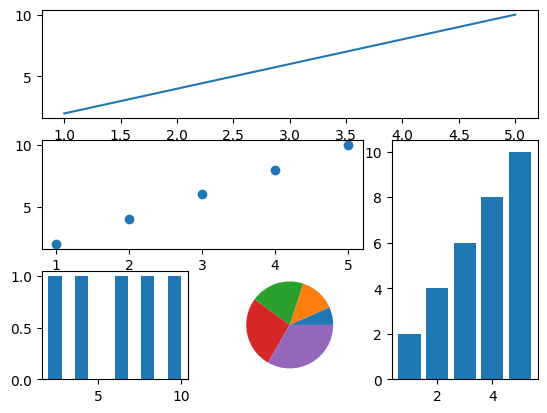

In [22]:


# Создание объекта GridSpec с заданными параметрами
gs = gridspec.GridSpec(3, 3)

# Создание подграфиков на основе GridSpec
ax1 = plt.subplot(gs[0, :])
ax2 = plt.subplot(gs[1, :-1])
ax3 = plt.subplot(gs[1:, -1])
ax4 = plt.subplot(gs[-1, 0])
ax5 = plt.subplot(gs[-1, -2])

# Рисование на подграфиках
ax1.plot([1, 2, 3, 4, 5], [2, 4, 6, 8, 10])
ax2.scatter([1, 2, 3, 4, 5], [2, 4, 6, 8, 10])
ax3.bar([1, 2, 3, 4, 5], [2, 4, 6, 8, 10])
ax4.hist([2, 4, 6, 8, 10])
ax5.pie([2, 4, 6, 8, 10])

# Отображение графиков
plt.show()

  0%|          | 0/1000 [00:00<?, ?it/s]

100%|██████████| 1000/1000 [00:18<00:00, 55.15it/s]


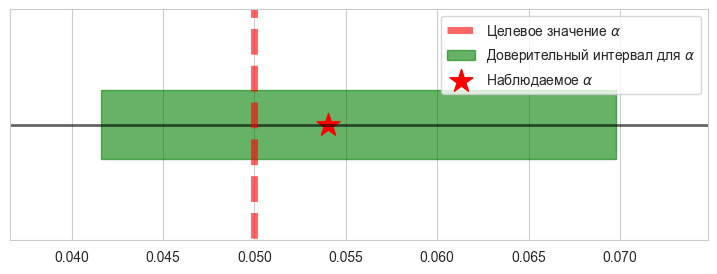

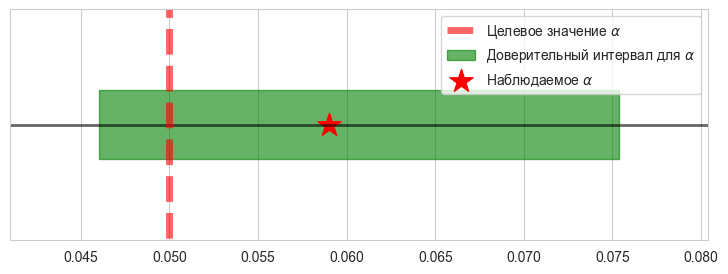

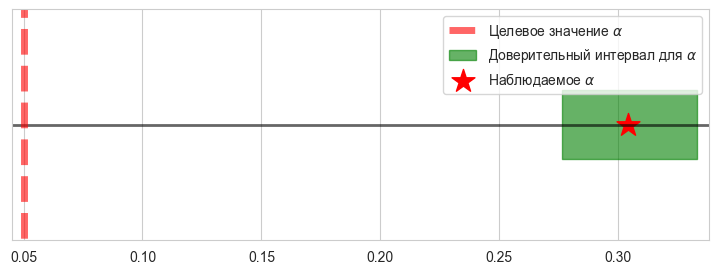

In [337]:
AB_test([sps.norm(10, 3), sps.norm(20, 3)], total_size=10**5)

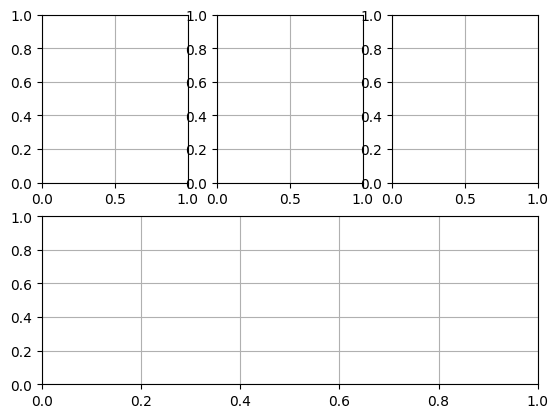

In [339]:
# Создание сетки с 2 строками и 3 столбцами
grid = plt.GridSpec(2, 3)

# Создание субграфиков на основе сетки
ax1 = plt.subplot(grid[0, 0])
ax2 = plt.subplot(grid[0, 1])
ax3 = plt.subplot(grid[0, 2])
ax4 = plt.subplot(grid[1, :])

# Настройка сетки для всех субграфиков
for ax in [ax1, ax2, ax3, ax4]:
    ax.grid(True)

# Отображение графиков
plt.show()

In [ ]:
def draw_mean_distr_by_main_distr(first_strat, strats, size=10 ** 3, n_iter=10 ** 4, figsize=(12, 8), total_size=10 ** 5):
    with sns.axes_style('darkgrid'):
        fig, axes = plt.subplots(2, len(strats), figsize=figsize)
        plt.suptitle('Распределение разности средних для разного количества страт, \n количество итераций: {}, размер выборок: {}'.format(n_iter, size))

        for pref, row in zip(range(1, len(strats) + 1), range(len(strats))):
            # print(strats[:pref], [total_size in range(pref)])
            mixed_d = MixedDistribution([first_strat], [total_size for i in range(pref)], draw_plot=False)
            mixed_d.draw_distr_plot(ax=axes[0, row])
            axes[0, row].set_xlabel('')
            axes[0, row].set_ylabel('')
            axes[0, row].set_title(f'Распределение из {pref} страт', fontsize=12)
            draw_mean_diff_plot(mixed_d, sample_size=size, n_iter=n_iter, ax=axes[1, row])
            # axes[1, row].set_title('')
            axes[1, row].set_title(f'Распределение разности средних\nиз распределения из {pref} страт', fontsize=12)
        
        handles, labels = axes[0, -1].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper left', fontsize='small')
        handles, labels = axes[1, -1].get_legend_handles_labels()
        fig.legend(handles, labels, loc='lower left', fontsize='small')
        # plt.legend()
        fig.supylabel('Плотность')
        fig.supxlabel('Значение')
        fig.show()

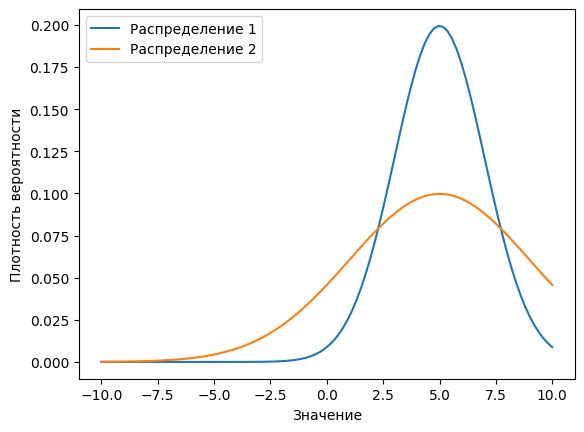

In [200]:
# Параметры первого распределения
mean1 = 5
std1 = 2

# Параметры второго распределения
mean2 = 5
std2 = 4

# Генерация данных для оси x
x = np.linspace(-10, 10, 100)

# Вычисление плотности вероятности для каждого распределения
pdf1 = sps.norm.pdf(x, mean1, std1)
pdf2 = sps.norm.pdf(x, mean2, std2)

# Построение графика
plt.plot(x, pdf1, label='Распределение 1')
plt.plot(x, pdf2, label='Распределение 2')

# Добавление легенды и меток осей
plt.legend()
plt.xlabel('Значение')
plt.ylabel('Плотность вероятности')

# Отображение графика
plt.show()
                                                                                                                               

In [ ]:
def draw_mi

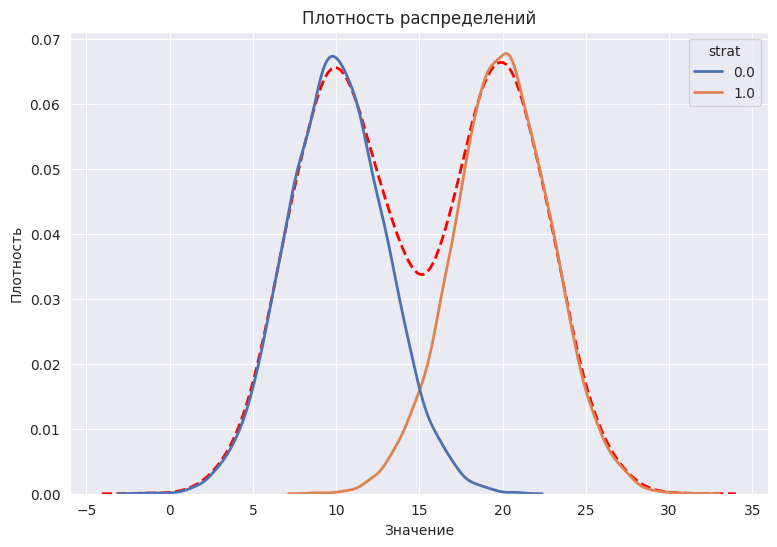

In [249]:
distrs = [sps.norm(10, 3), sps.norm(20, 3)]
size = 10 ** 4
sizes = [size for i in range(len(distrs))]
mixed_2_strat2 = MixedDistribution(distrs, sizes, draw_plot=True)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:07<00:00, 14.09it/s]


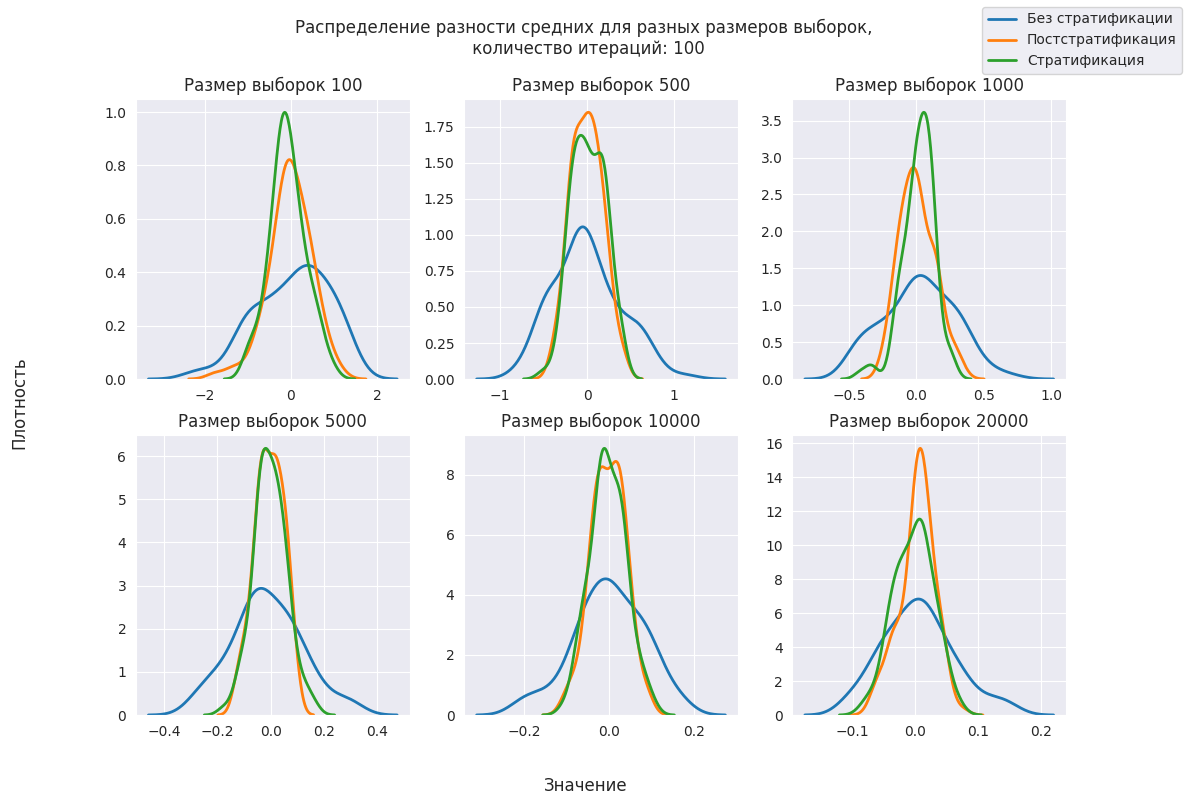

In [198]:
sizes = [100, 500, 1000, 5000, 10000, 20000]
draw_mean_diff_plots(mixed_2_strat2, sizes=sizes, n_iter=100, nrows=2, ncols=3, figsize=(12, 8))

Видим, что распределение разности средних при использовании стратификации значительно уже, чем в случае отстствии стратификации.  
Это верно даже для выборок относительно большого размера, при этом у нас в исходном распределении были сильно различающиеся страты.  
Давайте посмотрим, насколько сильно влияет стратификация в зависимости от различия в стратах и в зависимости от их количества.  

In [ ]:
def draw_strat_eff_by_shift(distr1, distr2, shifts):
    with 

In [ ]:
distrs = [sps.norm(10, 3), sps.norm(25, 5)]
size = 10 ** 6
sizes = [size for i in range(len(distrs))]
mixed_3_strat = MixedDistribution(distrs, sizes, draw_plot=True)

In [ ]:
sizes = [100, 500, 1000, 5000, 10000, 20000]
draw_mean_diff_plots(mixed_3_strat, sizes=sizes, nrows=2, ncols=3)

  0%|          | 0/100 [00:00<?, ?it/s]

100%|██████████| 100/100 [00:01<00:00, 97.36it/s]


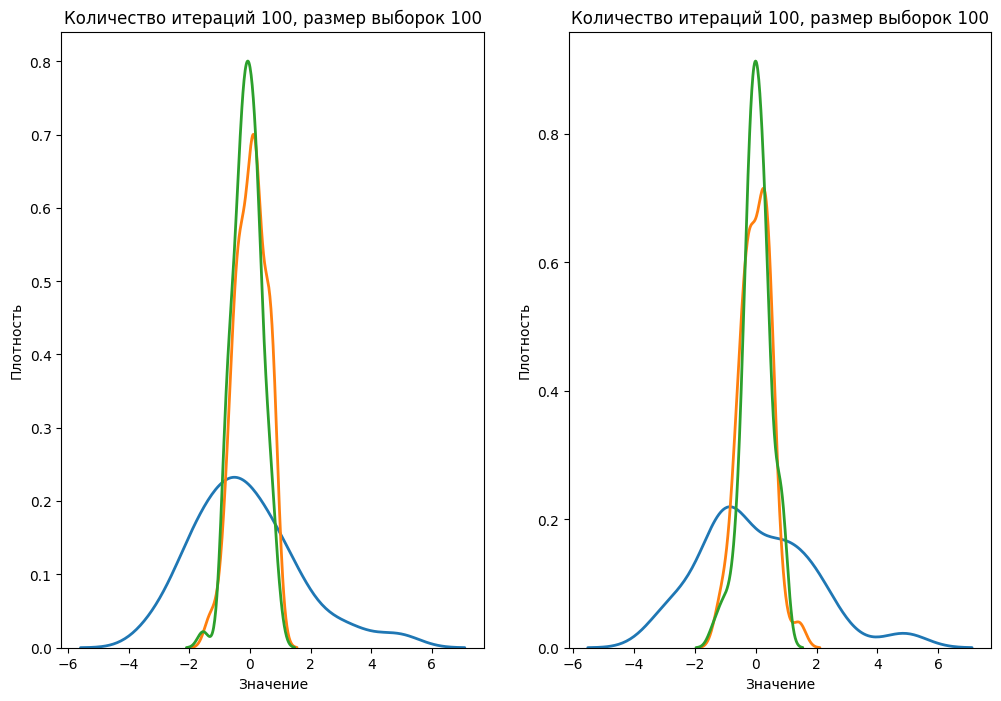

In [109]:
fig, axes = plt.subplots(1, 2, figsize=(12, 8))
for ax_ in axes:
    draw_mean_diff_plot(mixed, 100, 100, ax=ax_)

In [88]:
def 
strat_diff = []
poststrat_diff = []
nostrat_diff = []
n_iter = 10 ** 4
sample_size = 1000
for i in tqdm(range(n_iter)):
    X1, X2 = mixed.get_casual_partition(sample_size)
    nostrat_means = calc_casual_mean([X1, X2])
    nostrat_diff.append(nostrat_means[0] - nostrat_means[1])
    poststrat_means = calc_strat_mean([X1, X2], mixed)
    poststrat_diff.append(poststrat_means[0] - poststrat_means[1])
    X1_strat, X2_strat = mixed.get_strat_partition(sample_size)
    strat_means = calc_strat_mean([X1_strat, X2_strat], mixed)
    strat_diff.append(strat_means[0] - strat_means[1])

100%|██████████| 10000/10000 [01:47<00:00, 93.26it/s]


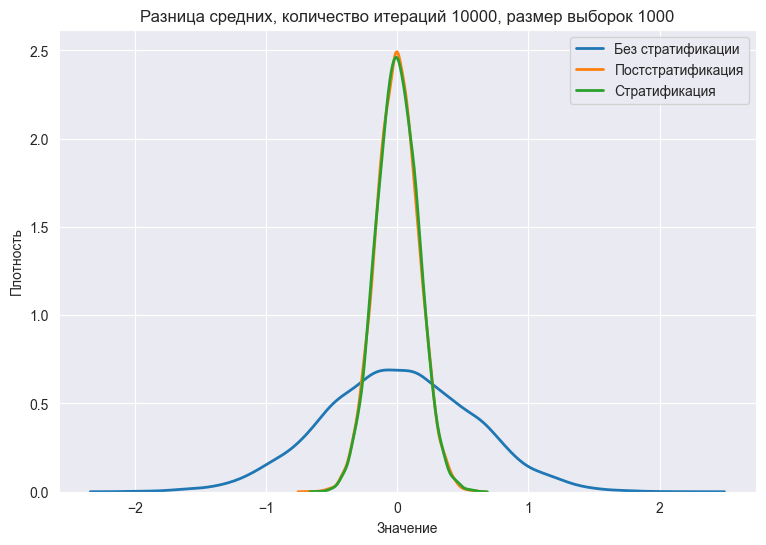

In [89]:
with sns.axes_style('darkgrid'):
    plt.figure(figsize=(9, 6))
    plt.title('Разница средних, количество итераций {}, размер выборок {}'.format(n_iter, sample_size))
    sns.kdeplot(x=nostrat_diff, lw=2, label='Без стратификации')
    sns.kdeplot(x=poststrat_diff, lw=2, label='Постстратификация')
    sns.kdeplot(x=strat_diff, lw=2, label='Стратификация')
    plt.xlabel('Значение')
    plt.ylabel('Плотность')
    plt.legend()
    plt.show()

Как мы видим, постстратификация и стратификация дают аналогичные результаты, при этом использование хоть какой-нибудь стратификации  
сильно уменьшает дисперсию разности средних в выборках.

In [90]:
strat_diff = []
poststrat_diff = []
nostrat_diff = []
n_iter = 10 ** 4
sample_size = 10 ** 4
for i in tqdm(range(n_iter)):
    X1, X2 = mixed.get_casual_partition(sample_size)
    nostrat_means = calc_casual_mean([X1, X2])
    nostrat_diff.append(nostrat_means[0] - nostrat_means[1])
    poststrat_means = calc_strat_mean([X1, X2], mixed)
    poststrat_diff.append(poststrat_means[0] - poststrat_means[1])
    X1_strat, X2_strat = mixed.get_strat_partition(sample_size)
    strat_means = calc_strat_mean([X1_strat, X2_strat], mixed)
    strat_diff.append(strat_means[0] - strat_means[1])

100%|██████████| 10000/10000 [01:57<00:00, 85.10it/s]


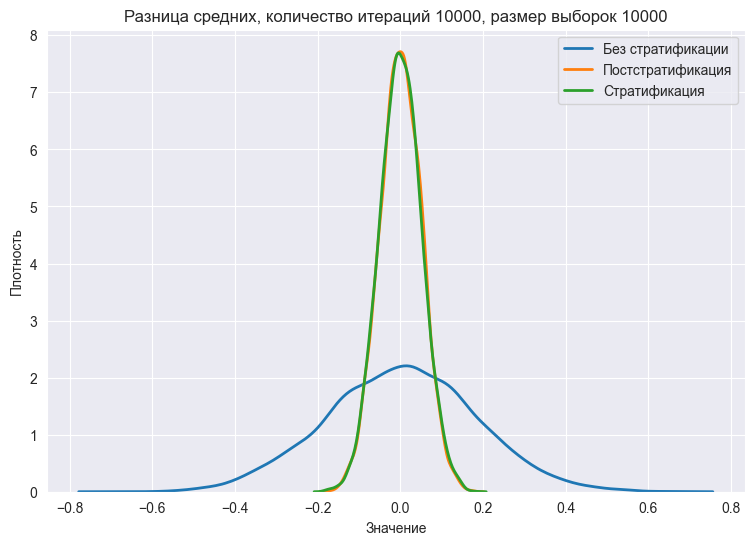

In [91]:
with sns.axes_style('darkgrid'):
    plt.figure(figsize=(9, 6))
    plt.title('Разница средних, количество итераций {}, размер выборок {}'.format(n_iter, sample_size))
    sns.kdeplot(x=nostrat_diff, lw=2, label='Без стратификации')
    sns.kdeplot(x=poststrat_diff, lw=2, label='Постстратификация')
    sns.kdeplot(x=strat_diff, lw=2, label='Стратификация')
    plt.xlabel('Значение')
    plt.ylabel('Плотность')
    plt.legend()
    plt.show()

In [92]:
strat_diff = []
poststrat_diff = []
nostrat_diff = []
n_iter = 10 ** 3
sample_size = 10 ** 5
for i in tqdm(range(n_iter)):
    X1, X2 = mixed.get_casual_partition(sample_size)
    nostrat_means = calc_casual_mean([X1, X2])
    nostrat_diff.append(nostrat_means[0] - nostrat_means[1])
    poststrat_means = calc_strat_mean([X1, X2], mixed)
    poststrat_diff.append(poststrat_means[0] - poststrat_means[1])
    X1_strat, X2_strat = mixed.get_strat_partition(sample_size)
    strat_means = calc_strat_mean([X1_strat, X2_strat], mixed)
    strat_diff.append(strat_means[0] - strat_means[1])

100%|██████████| 1000/1000 [00:32<00:00, 30.67it/s]


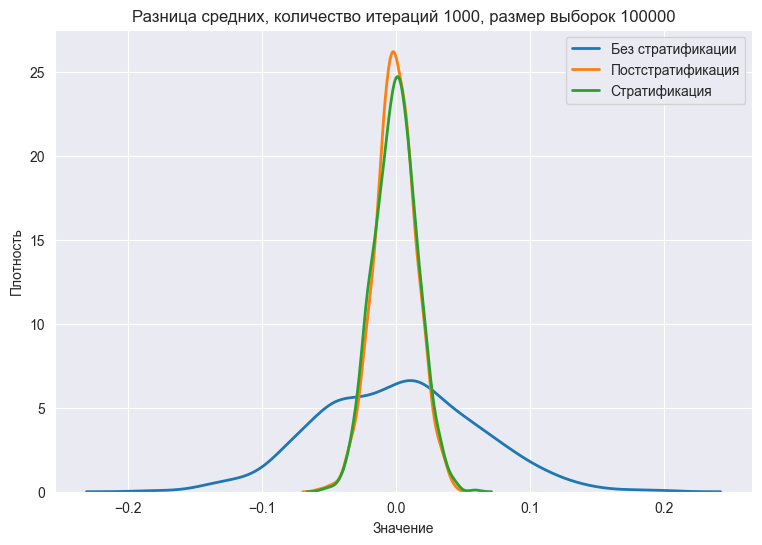

In [93]:
with sns.axes_style('darkgrid'):
    plt.figure(figsize=(9, 6))
    plt.title('Разница средних, количество итераций {}, размер выборок {}'.format(n_iter, sample_size))
    sns.kdeplot(x=nostrat_diff, lw=2, label='Без стратификации')
    sns.kdeplot(x=poststrat_diff, lw=2, label='Постстратификация')
    sns.kdeplot(x=strat_diff, lw=2, label='Стратификация')
    plt.xlabel('Значение')
    plt.ylabel('Плотность')
    plt.legend()
    plt.show()

In [95]:
strat_diff = []
poststrat_diff = []
nostrat_diff = []
n_iter = 10 ** 3
sample_size = 10 ** 5
for i in tqdm(range(n_iter)):
    X1, X2 = mixed2.get_casual_partition(sample_size)
    nostrat_means = calc_casual_mean([X1, X2])
    nostrat_diff.append(nostrat_means[0] - nostrat_means[1])
    poststrat_means = calc_strat_mean([X1, X2], mixed2)
    poststrat_diff.append(poststrat_means[0] - poststrat_means[1])
    X1_strat, X2_strat = mixed2.get_strat_partition(sample_size)
    strat_means = calc_strat_mean([X1_strat, X2_strat], mixed2)
    strat_diff.append(strat_means[0] - strat_means[1])

100%|██████████| 1000/1000 [00:26<00:00, 37.27it/s]


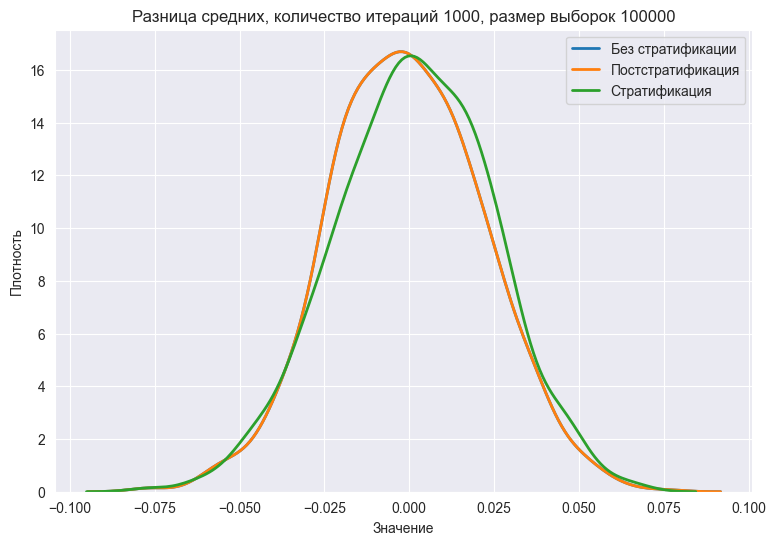

In [96]:
with sns.axes_style('darkgrid'):
    plt.figure(figsize=(9, 6))
    plt.title('Разница средних, количество итераций {}, размер выборок {}'.format(n_iter, sample_size))
    sns.kdeplot(x=nostrat_diff, lw=2, label='Без стратификации')
    sns.kdeplot(x=poststrat_diff, lw=2, label='Постстратификация')
    sns.kdeplot(x=strat_diff, lw=2, label='Стратификация')
    plt.xlabel('Значение')
    plt.ylabel('Плотность')
    plt.legend()
    plt.show()

Как можно видеть

In [67]:
a, b = mixed.get_casual_partition(100)

In [70]:
a.value.mean()

25.656392174496283

In [72]:
calc_casual_mean([a, b])

[25.656392174496283, 23.69184551402225]

In [74]:
a, b = mixed.get_strat_partition(1000)

In [76]:
calc_strat_mean([a, b], mixed)

[25.156262255091413, 25.054248257977243]

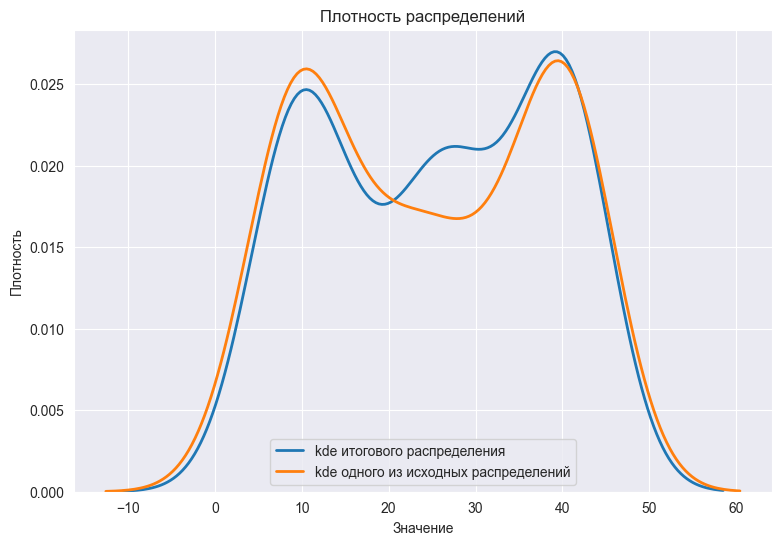

In [78]:
with sns.axes_style('darkgrid'):
    plt.figure(figsize=(9, 6))
    plt.title('Плотность распределений')
    a, b = mixed.get_casual_partition(100)
    sns.kdeplot(data=a, x='value', lw=2, label='kde итогового распределения')
    a, b = mixed.get_strat_partition(100)
    sns.kdeplot(data=a, x='value', lw=2, label='kde одного из исходных распределений')
    plt.xlabel('Значение')
    plt.ylabel('Плотность')
    plt.legend()
    plt.show()

In [53]:
len(a), len(b)

(10, 10)

In [55]:
a.value.mean()

36.796209823653385

In [59]:
np.array(a.groupby(by='strat').mean().value)

array([32.0428192, 39.9651369])

In [61]:
x = np.array([1, 2, 3])
y = np.array([5, 6 ,7])
(x * y).sum()

38

In [54]:
a.head()

,value,strat
23623,39.861292,2.0
23650,39.115170,2.0
19593,32.362907,1.0
25437,40.852789,2.0
26067,40.109517,2.0


In [30]:
mixed.get_strat_partition(10)

[array([ 6.78596739,  9.05189301, 10.24280044, 33.35292063, 35.01225899,
        34.57517112, 40.28634479, 41.07400767, 39.46562733]),
 array([15.43029259,  5.60346624, 11.71732571, 38.75723875, 19.71503368,
        23.75912125, 38.84208139, 41.86075623, 40.2230637 ])]

In [ ]:
class MyClass:
    def __init__(self, name):
        self.name = name

    def say_hello(self):
        print("Hello, " + self.name + "!")

    def get_name_length(self):
        return len(self.name)

    def multiply_numbers(self, num1, num2):
        return num1 * num2

# Создаем экземпляр класса
obj = MyClass("John")

# Вызываем функции объекта
obj.say_hello()
name_length = obj.get_name_length()
print("Name length:", name_length)
result = obj.multiply_numbers(3, 4)
print("Multiplication result:", result)

Hello, John!
Name length: 4
Multiplication result: 12


In [ ]:
np.array((data.groupby(by='group').count() / data.groupby(by='group').count().sum())['value'])

array([0.33333333, 0.33333333, 0.33333333])

In [ ]:
def create_mixed_sample(distrs, sizes, draw_plot=False):
    sample, groups = np.array([]), np.array([])
    for i, distr in enumerate(distrs):
        sample = np.concatenate((sample, distr.rvs(size=sizes[i])))
        groups = np.concatenate((groups, np.full(sizes[i], i)))
 
    sample_df = pd.DataFrame({'value': sample, 'group': groups})
    if draw_plot:
        with sns.axes_style('darkgrid'):
            plt.figure(figsize=(9, 6))
            plt.title('Плотность распределений')
            sns.kdeplot(data=sample_df, x='value', color='r' , linestyle='--', lw=2, label='kde итогового распределения')
            sns.kdeplot(data=sample_df, x='value', hue='group', lw=2, palette='deep', label='kde одного из исходных распределений')
            plt.xlabel('Значение')
            plt.ylabel('Плотность')
            plt.legend()
            plt.show()
    return sample_df

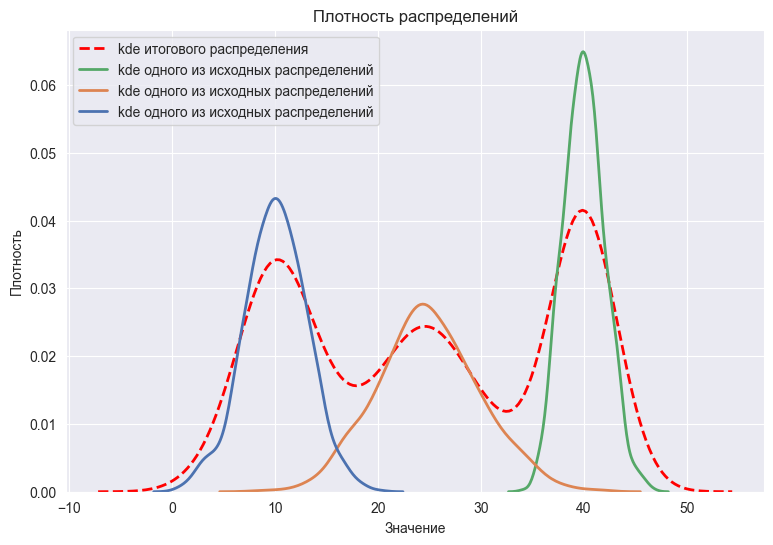

In [ ]:
distrs = [sps.norm(10, 3), sps.norm(25, 5), sps.norm(40, 2)]
size = 10 ** 3
sizes = [size for i in range(3)]
data = create_mixed_sample(distrs, sizes, draw_plot=True)

Теперь напишем функцию, которая равномерно семплирует выборки из страт.  


In [ ]:
group_count = sample.groupby(by='group').count()
weights = group_count / group_count.sum()
weights

,value
group,
0.0,0.333333
1.0,0.333333
2.0,0.333333


In [ ]:
def casual_sampler(data_):
    data = data_.copy()
    data['test_group'] = sps.bernoulli(p=0.5).rvs(size=len(data))
    return data[data.test_group == 0], data[data.test_group == 1]

In [ ]:
def stratified_sampler(data_):
    data = data_.copy()
    group_count = data.groupby(by='group').count()
    groups = np.array([])
    for size in group_count.value:
        group_type = sps.bernoulli(p=0.5).rvs(size=size)
        groups = np.concatenate((groups, group_type))
    data['test_group'] = groups.astype(int)
    return data[data.test_group == 0], data[data.test_group == 1]